In [1]:
import numpy as np 
import torch
from torch import nn
from tqdm import tqdm 
import matplotlib.pyplot as plt 
from svr import SVR

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using GPU!")
else:
    DEVICE = torch.device("cpu")


Using GPU!


# VGG 

In [2]:

import torch
from svr import SVR
import matplotlib.pyplot as plt 
 
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19_bn',pretrained=True)

weights= [ w.detach() for w in model.parameters() if len(w.shape)>1 ]
# This definion of weights discards scaling induced by batchnorm 
# this does not really matter for our experiments 
svr = SVR(weights,method='svr',max_dim_svd=600)


Using cache found in /home/meller/.cache/torch/hub/pytorch_vision_v0.10.0
100%|███████████████████████████████████████████| 19/19 [01:45<00:00,  5.54s/it]


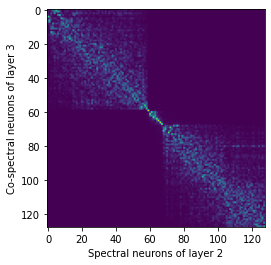

In [3]:
# Adjacency HOSVD

layer = 2
A = weights[layer]
B = weights[layer+1]

randNormA = torch.normal(torch.zeros(A.shape[0],A.shape[0]),1)
randRotA,_,_  = torch.svd(randNormA) 
randNormB = torch.normal(torch.zeros(A.shape[0],A.shape[0]),1)
randRotB,_,_  = torch.svd(randNormB) 


_,S1,V = torch.svd((B.transpose(0,1).flatten(start_dim=1).transpose(0,1))@randRotB) # oz,i
U,S2,_ =  torch.svd(randRotA@A.flatten(start_dim=1))
U,V = randRotA.T@U,(randRotB@V) 
#We use random rotations to eliminate any bias due to the canonical basis

adja = torch.abs(V.T@U)

plt.imshow(adja)
plt.xlabel('Spectral neurons of layer '+str(layer))
plt.ylabel('Co-spectral neurons of layer '+str(layer+1))
plt.show()


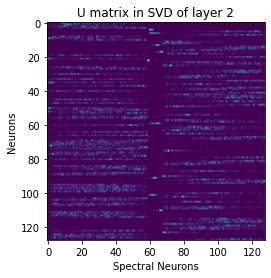

In [4]:
plt.imshow(torch.abs(U))
plt.xlabel('Spectral Neurons')
plt.ylabel('Neurons')
plt.title('U matrix in SVD of layer '+str(layer))
plt.show()

# Visualizing spectral images

In [5]:
#Helper functions 
import torch.nn as nn 
from torchvision import datasets, models, transforms
import os 

class Truncated(nn.Module):
    """Create a truncated PyTorch model from VGG nets."""
    
    def __init__(self,model,trunc_idx):
        super(Truncated, self).__init__()    
        model.eval()
        self.model = model
        self.trunc_idx = trunc_idx 
        self.arch = ""
        i = 0 
        conv_n = 0 
        for layer in model.named_modules():
            if i > self.trunc_idx:
                break
            if not ('VGG' in str(type(layer[1])) or 'Sequential' in str(type(layer[1]))):
                if 'conv' in str(type(layer[1])):
                    self.arch += str(i) +"-"+str(type(layer[1])).split('.')[3] +str(conv_n)+" \n"
                    conv_n+=1 
                else:
                    self.arch += str(i) +"-"+str(type(layer[1])).split('.')[3] +" \n"
                i+=1 
                
    def forward(self,x):
        idx = 0 
        for layer in model.named_modules():
            if idx >self.trunc_idx:
                return x 
            if not ('VGG' in str(type(layer[1])) or 'Sequential' in str(type(layer[1]))): 
                #print(type(layer[1]),x.shape)
                x = layer[1](x)
                idx+=1 
        return x 

def convID2layerID(model,conv_idx):
    """Helper function to determine the id of conv layers used by the network."""
    
    conv_n,i=0,0
    for layer in model.named_modules():
            if not ('VGG' in str(type(layer[1])) or 'Sequential' in str(type(layer[1]))):
                if 'conv' in str(type(layer[1])):
                    if conv_n==conv_idx:
                        return i 
                    conv_n+=1 
                    
                i+=1 
                

data_transforms = {
    'imagenet-sample-images': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './img/'
data = datasets.ImageFolder(data_dir,data_transform)

def imshow(inp, title=None):
    """Imshow for tensors."""
    
    inp = inp.to('cpu').numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.show()
        
def print_spectral_images(x,spectral_neurons=[0,1,2,10,-4,-1],layers=list(range(5,11))):
    """Display spectral images for specific spectral neurons.
    
    Arguments 
    ---------
    x (tensor) : image of shape [3,224,224]
    spectral_neurons (list of int) : list of spectral neurons for which
        to show spectral activation images, 0 corresponds to the spectral neuron 
        of highest singular value. Negative numbers can be used. 
    layers (list of int) : list of conv layers id for which to display spectral images
    """
    print("Spectral neurons (rows) : ",spectral_neurons)
    print("Layers (columns) : ",layers)
    
    x = x.unsqueeze(0)
    columns = len(layers)
    rows = len(spectral_neurons)
    fig = plt.figure(figsize=(15, 10))
    w,h = 10,10
    i=1
    for feature in spectral_neurons:
        for conv_idx in layers:
            trunc_idx = convID2layerID(model,conv_idx)-1
            v= svr.V[conv_idx][:,:,:,feature].unsqueeze(0)
            trunc = Truncated(model,trunc_idx)
            y = trunc(x)
            img = torch.nn.functional.conv2d(y,v).detach()
            img = torch.abs(img.squeeze(0).squeeze(0))
            fig.add_subplot(rows, columns, i)
            plt.imshow(img)
            plt.axis('off')
            i+=1
    plt.show()     

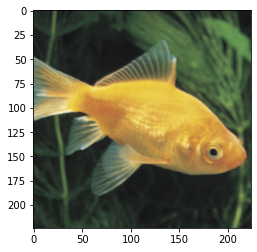

Spectral neurons (rows) :  [0, 1, -1]
Layers (columns) :  [5, 6, 7, 8, 9, 10]


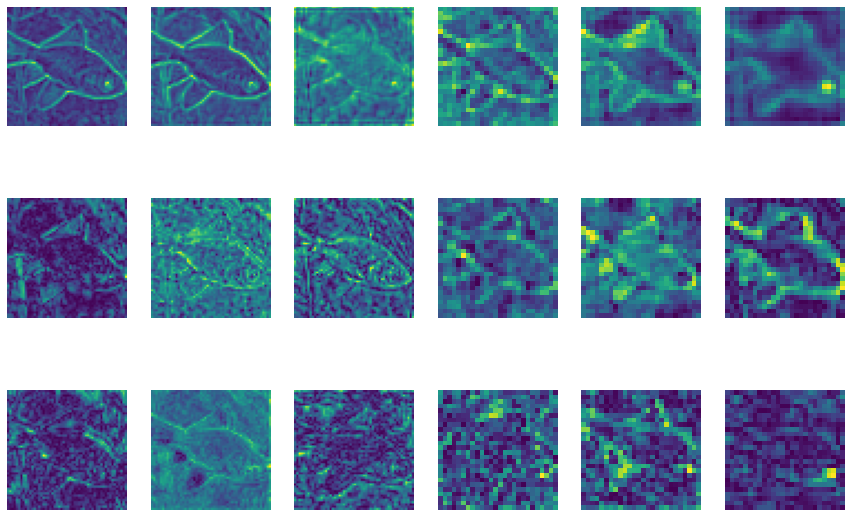

In [6]:
#Display spectral activations
idx = 0 #1
x = data[idx][0]
imshow(x)
print_spectral_images(x,spectral_neurons=[0,1,-1])

# Modeling baseline distribution of adjacency coefficients 

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 992.03it/s]


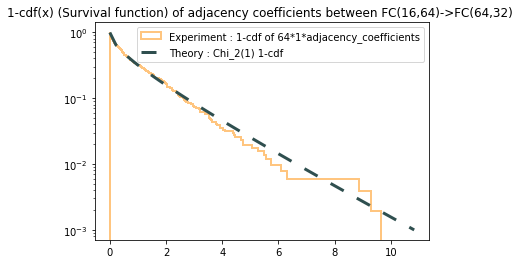

In [9]:
# Agreement chi2-svr 
from scipy.stats import chi2,norm

# Parameters for convolutional layer
""" 
c,z = 5,3*3
w1 = torch.randn(c,16,3,3)
w2 = torch.randn(32,c,3,3)
""" 
# Parameter for fully connected layer 

c,z = 64,1
w1 = torch.randn(c,16)
w2 = torch.randn(32,c)

conv_svr = SVR([w1,w2])
a = conv_svr.adjacency[0].flatten().numpy()
a_normalized = a*z*c


plt.hist(a_normalized,label="Experiment : 1-cdf of 64*1*adjacency_coefficients",
         alpha=0.5,lw=2,bins=500,density=True,cumulative=-1,histtype='step',color='darkorange')
plt.yscale('log')
x = np.linspace(chi2.ppf(0.01, z),chi2.ppf(0.999, z), 50)
plt.plot(x, 1-chi2.cdf(x, z),linestyle=(0, (5, 5)), lw=3, label='Theory : Chi_2(1) 1-cdf',color='darkslategrey')
plt.legend()
plt.title('1-cdf(x) (Survival function) of adjacency coefficients between FC(16,64)->FC(64,32) ')
plt.show()